In [1]:
from typing import Callable, Tuple
from IPython.core.display_functions import display
from sklearn.datasets import make_classification, make_moons
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay, auc, roc_auc_score, f1_score, balanced_accuracy_score
from time import time_ns, time
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from scipy.optimize import minimize, LinearConstraint, Bounds, BFGS
plt.rcParams["figure.figsize"] = (20,10)
ZERO = 1e-5
random_state = 244827
n_samples = 2427

In [2]:
class PUMData:
    def __init__(self, gen, random_state=244827, test_size=0.2):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(gen[0], gen[1], test_size=test_size, random_state=random_state, shuffle=True, stratify=gen[1])
        self.big_x_train, self.small_x_train, self.big_y_train, self.small_y_train = train_test_split(self.x_train, self.y_train, test_size=0.05)

    def normalize(self, min_v=0, max_v=1):
        for i in range(self.x_train.shape[1]):
            x_min = np.min(self.x_train[:, i])
            x_max = np.max(self.x_train[:, i])
            if x_min != x_max:
                self.x_train[:, i] = (self.x_train[:, i] - x_min) / (x_max - x_min)
                self.x_train[:, i] = self.x_train[:, i] * (max_v - min_v) + min_v

                self.x_test[:, i] = (self.x_test[:, i] - x_min) / (x_max - x_min)
                self.x_test[:, i] = self.x_test[:, i] * (max_v - min_v) + min_v
            else:
                self.x_train[:, i] = 1
                self.x_test[:, i] = 1

    def change_labels(self, old: list, new: list):
        for o, n in zip(old, new):
            self.y_test[self.y_test == o] = n
            self.y_train[self.y_train == o] = n
            self.big_y_train[self.big_y_train == o] = n
            self.small_y_train[self.small_y_train == o] = n

    def winsorize(self):
        for i in range(self.x_train.shape[1]):
            if len(np.unique(self.x_train[:, i])) == 2:
                continue
            q1_train = np.percentile(self.x_train[:, i], 25)
            q3_train = np.percentile(self.x_train[:, i], 75)
            iqr_train = q3_train - q1_train
            self.x_train[:, i] = np.clip(self.x_train[:, i], q1_train - 1.5 * iqr_train, q3_train + 1.5 * iqr_train)

            q1_test = np.percentile(self.x_test[:, i], 25)
            q3_test = np.percentile(self.x_test[:, i], 75)
            iqr_test = q3_test - q1_test
            self.x_test[:, i] = np.clip(self.x_test[:, i], q1_test - 1.5 * iqr_test, q3_test + 1.5 * iqr_test)

    def make_polynomial(self, poly_degree=2, include_bias=False):
        self.x_test = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_test)
        self.x_train = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_train)

In [53]:
def _fast_lagrange_function(alpha: ndarray, x: ndarray, y:ndarray):
    res = np.zeros((alpha.shape[0], alpha.shape[0]))
    for i in range(alpha.shape[0]):
        res[i] = np.dot(alpha, alpha[i]) * np.dot(y, y[i]) * np.dot(x, x[i])
    return 0.5 * res.sum() - alpha.sum()


class MySVM:
    ACCEPTED_KERNELS = ['linear', 'poly', 'rbf']

    @staticmethod
    def _linear_kernel(x1, x2, *args):
        return np.dot(x1, x2)

    @staticmethod
    def _poly_kernel(x1, x2, *args):
        return (1 + np.inner(x1, x2)) ** args[0]

    @staticmethod
    def _rbf_kernel(x1, x2, *args):
        return np.exp(-args[1] * np.linalg.norm(x1 - x2) ** 2)

    def __init__(self, C=1, kernel='rbf', gamma=0.1, degree=2, random_state=244827):
        if kernel not in self.ACCEPTED_KERNELS:
            raise ValueError(f'kernel {kernel} is not supported')
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.random_state = random_state
        self.kernel_function = {'linear': self._linear_kernel, 'poly': self._poly_kernel, 'rbf': self._rbf_kernel}[kernel]
        self.coef_ = None
        self.intercept_ = None
        self.alpha_ = None
        self.x_train = None
        self.y_train = None

    def _lagrange_function(self, alpha, x, y):
        res = np.zeros((alpha.shape[0], alpha.shape[0]))
        for i in range(alpha.shape[0]):
            res[i] = np.dot(alpha, alpha[i]) * np.dot(y, y[i]) * self.kernel_function(x, x[i], self.degree, self.gamma)

        return alpha.sum() - 0.5*res.sum()

    def fit(self, x_train, y_train):
        n, m = x_train.shape
        self.x_train = x_train
        self.y_train = y_train
        np.random.seed(self.random_state)
        alpha_start = np.random.uniform(0, self.C, n)
        linear_constraint = LinearConstraint(y_train, [0], [0])
        bounds = Bounds(np.zeros(n), np.full(n, self.C))
        result = minimize(self._lagrange_function, alpha_start, args=(x_train, y_train), method='trust-constr', hess=BFGS(),
                          constraints=[linear_constraint], bounds=bounds)
        self.alpha_ = result.x
        self.alpha_[self.alpha_ < ZERO] = 0
        self.coef_ = np.zeros(m)

        for i in range(n):
            if self.alpha_[i] != 0:
                self.coef_ += self.alpha_[i] * y_train[i] * x_train[i]

        self.intercept_ = 0
        c_num = self.C - ZERO
        indices = np.where((self.alpha_ != 0) & (self.alpha_ < c_num))[0]
        for i in indices:
            self.intercept_ += y_train[i] - np.dot(self.coef_, x_train[i])
        self.intercept_ /= len(indices)
        return self

    def decision_function(self, X):
        if self.coef_ is None or self.intercept_ is None:
            raise ValueError('Model is not fitted yet')

        c_num = self.C - ZERO
        indices = np.where((self.alpha_ != 0) & (self.alpha_ < c_num))[0]
        ret = []
        for xi in X:
            ret.append(sum([self.alpha_[i] * self.y_train[i] * self.kernel_function(xi, self.x_train[i], self.degree, self.gamma) for i in indices]))

        return ret

    def predict(self, x):
        if self.coef_ is None or self.intercept_ is None:
            raise ValueError('Model is not fitted yet')
        return np.sign(self.decision_function(x))


In [ ]:
data_moons = PUMData(make_moons(n_samples=n_samples, noise=0.1, random_state=random_state), random_state=random_state)
data_moons.change_labels([0], [-1])
new_my_model_poly = MySVM(C=1, kernel='poly', degree=3, gamma=0.1)
new_my_model_poly.fit(data_moons.small_x_train, data_moons.small_y_train)


In [43]:
test = new_my_model_poly.predict(data_moons.x_test)

In [44]:
print(test)

[ 1.  1. -1. -1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1.
  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1. -1.
  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1.
  1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1.
  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1. -1.
  1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.
  1.  1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.  1.  1. -1.  1. -1.  1.  1. -1.
  1.  1. -1.  1. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1. -1.
  1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1.  1.
 -1. -1.  1.  1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1.  1.
  1.  1.  1. -1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.
 -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1

In [54]:
def compare_models(my_model, sk_model, data: PUMData):
    x_min, x_max = data.x_test[:, 0].min() - 0.25, data.x_test[:, 0].max() + 0.25
    y_min, y_max = data.x_test[:, 1].min() - 0.25, data.x_test[:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    mesh_data = np.c_[xx.ravel(), yy.ravel()]

    Z_an = my_model.predict(mesh_data).reshape(xx.shape)
    Z_sk = sk_model.predict(mesh_data).reshape(xx.shape)

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(20, 15))

    for idx, Z, title in zip(
        range(2),
        [Z_an, Z_sk],
        ['Implementacja własna', 'Model SVC']):
        axarr[idx].contourf(xx, yy, Z, alpha=0.4, levels=1)
        axarr[idx].scatter(data.x_test[:, 0], data.x_test[:, 1], c=data.y_test, s=20, edgecolor="k")
        axarr[idx].set_title(title)

    plt.show()

    y_an_predicted = my_model.predict(data.x_test)
    y_sk_predicted = sk_model.predict(data.x_test)

    cm_sk = confusion_matrix(data.y_test, y_sk_predicted, labels=[-1, 1])
    cm_an = confusion_matrix(data.y_test, y_an_predicted, labels=[-1, 1])

    sensitivity_sk = cm_sk[1, 1] / (cm_sk[1, 0] + cm_sk[1, 1])
    specifity_sk = cm_sk[0, 0] / (cm_sk[0, 0] + cm_sk[0, 1])

    sensitivity_an = cm_an[1, 1] / (cm_an[1, 0] + cm_an[1, 1])
    specifity_an = cm_an[0, 0] / (cm_an[0, 0] + cm_an[0, 1])

    print(f'Model własny: Czulość: {sensitivity_an}, swoistość: {specifity_an}, Adjusted accuracy={balanced_accuracy_score(data.y_test, y_an_predicted, adjusted=True)}')
    print(f'Model sklearn: Czulość: {sensitivity_sk}, swoistość: {specifity_sk}, Adjusted accuracy={balanced_accuracy_score(data.y_test, y_sk_predicted, adjusted=True)}')

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(15, 8))

    for idx, cm, title in zip(
        range(2),
        [cm_an, cm_sk],
        ['Implementacja własna', 'Model SVC']
    ):
        sns.heatmap(cm, annot=True, fmt="d", ax=axarr[idx], cmap="Blues")
        axarr[idx].set_title(title)

    plt.show()

    my_function = my_model.decision_function(data.x_test)
    sk_function = sk_model.decision_function(data.x_test)

    fpr, tpr, thresholds = roc_curve(data.y_test, my_function)
    plt.plot(fpr, tpr, label=f'my model, AUC={roc_auc_score(data.y_test, my_function):.3f}')
    fpr, tpr, thresholds = roc_curve(data.y_test, sk_function)
    plt.plot(fpr, tpr, label=f'sklearn model, AUC={roc_auc_score(data.y_test, sk_function):.3f}')
    plt.legend()
    plt.show()

In [55]:
data_linear = PUMData(make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, random_state=random_state), random_state=random_state)
data_linear.change_labels([0], [-1])

In [56]:
my_model = MySVM(C=1, kernel='linear', gamma=0.1, degree=1)
start = time()
my_model.fit(data_linear.small_x_train, data_linear.small_y_train)
print(f'Time: {time() - start}')

Time: 14.034370422363281


In [32]:
sk_model = SVC(C=1, kernel='linear', gamma=0.1, degree=1, random_state=random_state)
sk_model.fit(data_linear.small_x_train, data_linear.small_y_train)

SVC(C=1, degree=1, gamma=0.1, kernel='linear', random_state=244827)

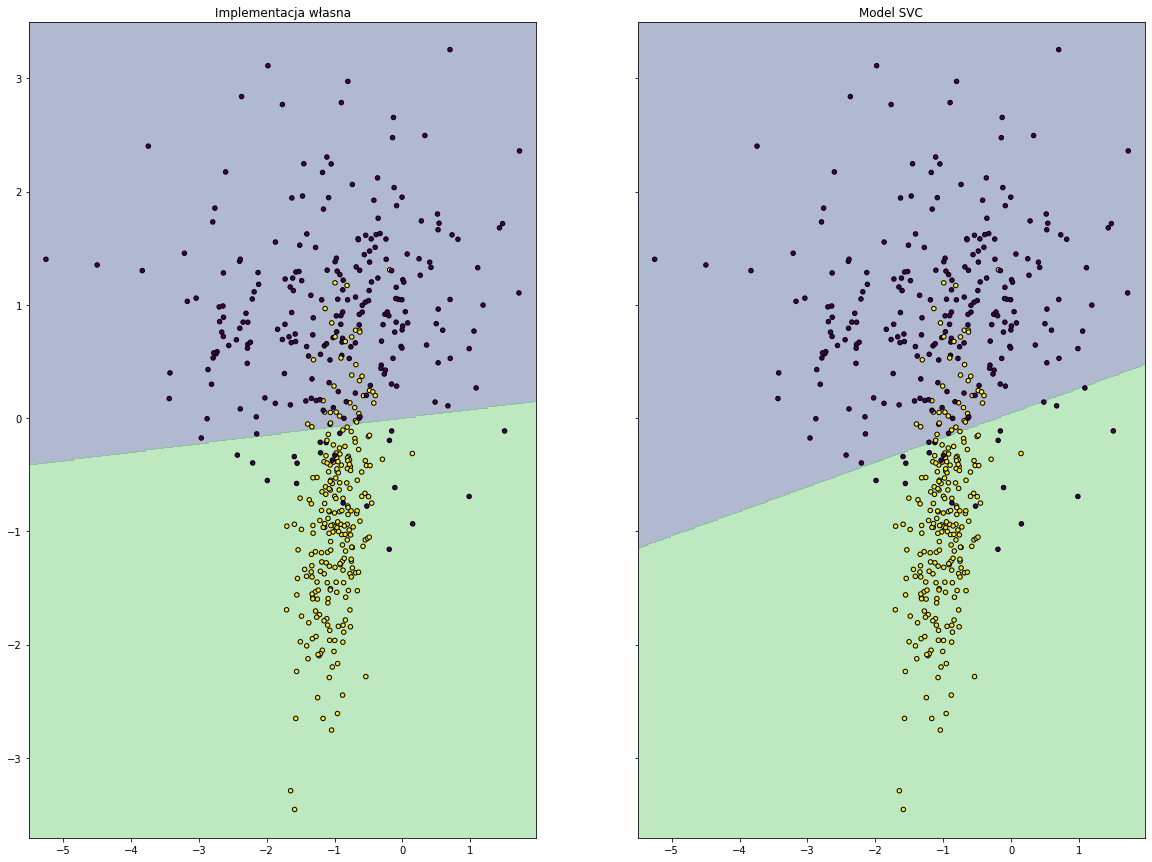

Model własny: Czulość: 0.8524590163934426, swoistość: 0.9132231404958677, Adjusted accuracy=0.7656821568893104
Model sklearn: Czulość: 0.8319672131147541, swoistość: 0.9173553719008265, Adjusted accuracy=0.7493225850155807


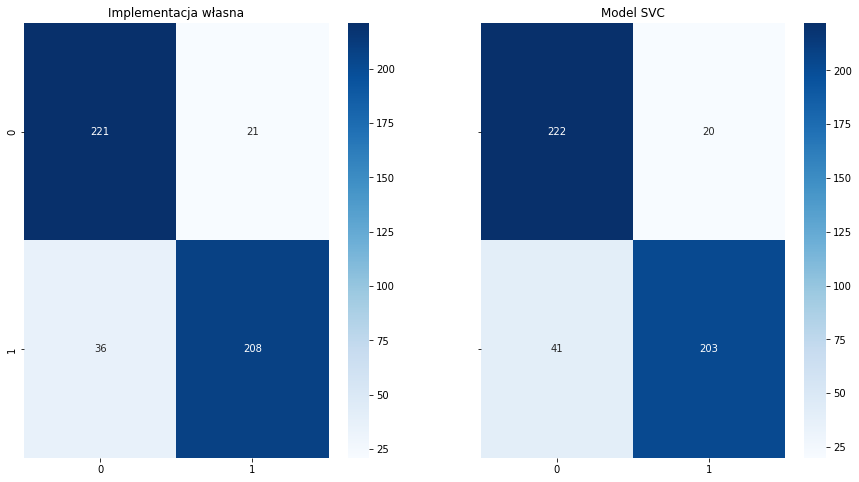

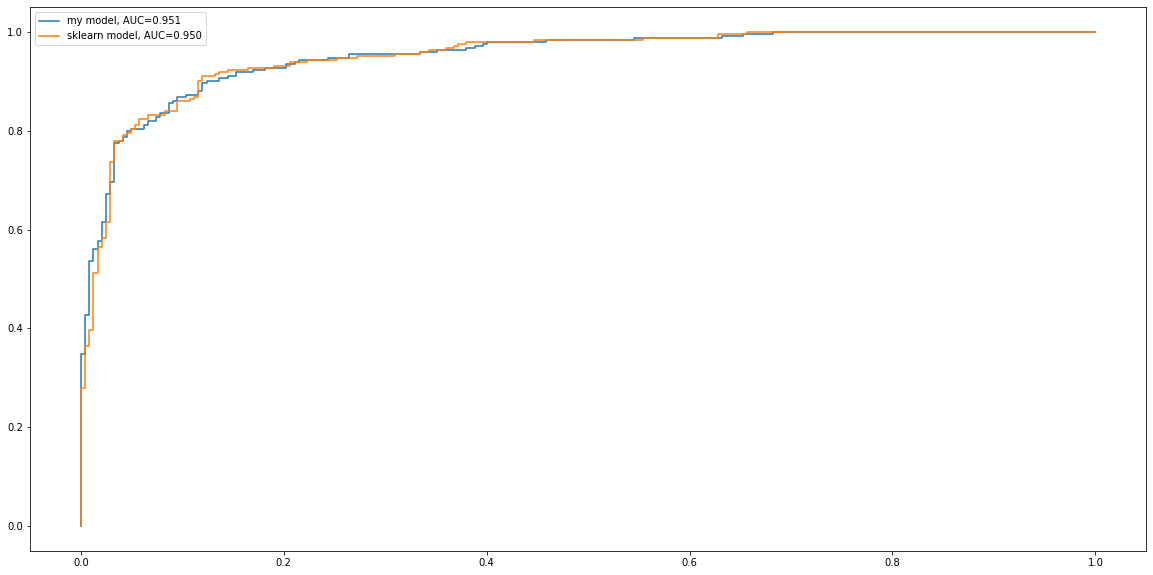

In [57]:
compare_models(my_model, sk_model, data_linear)

In [48]:
data_moons = PUMData(make_moons(n_samples=n_samples, noise=0.1, random_state=random_state), random_state=random_state)
data_moons.change_labels([0], [-1])
new_my_model_poly = MySVM(C=1, kernel='poly', degree=3, gamma=0.1)
new_my_model_poly.fit(data_moons.small_x_train, data_moons.small_y_train)
print(f'My model coefs: {new_my_model_poly.coef_}')
print(f'My model intercept: {new_my_model_poly.intercept_}')

My model coefs: [ 47.81690322 -33.65816676]
My model intercept: -17.785323304141873


In [49]:
sk_model_poly = SVC(C=1, kernel='poly', degree=3, gamma=0.1, random_state=random_state)
sk_model_poly.fit(data_moons.small_x_train, data_moons.small_y_train)

SVC(C=1, gamma=0.1, kernel='poly', random_state=244827)

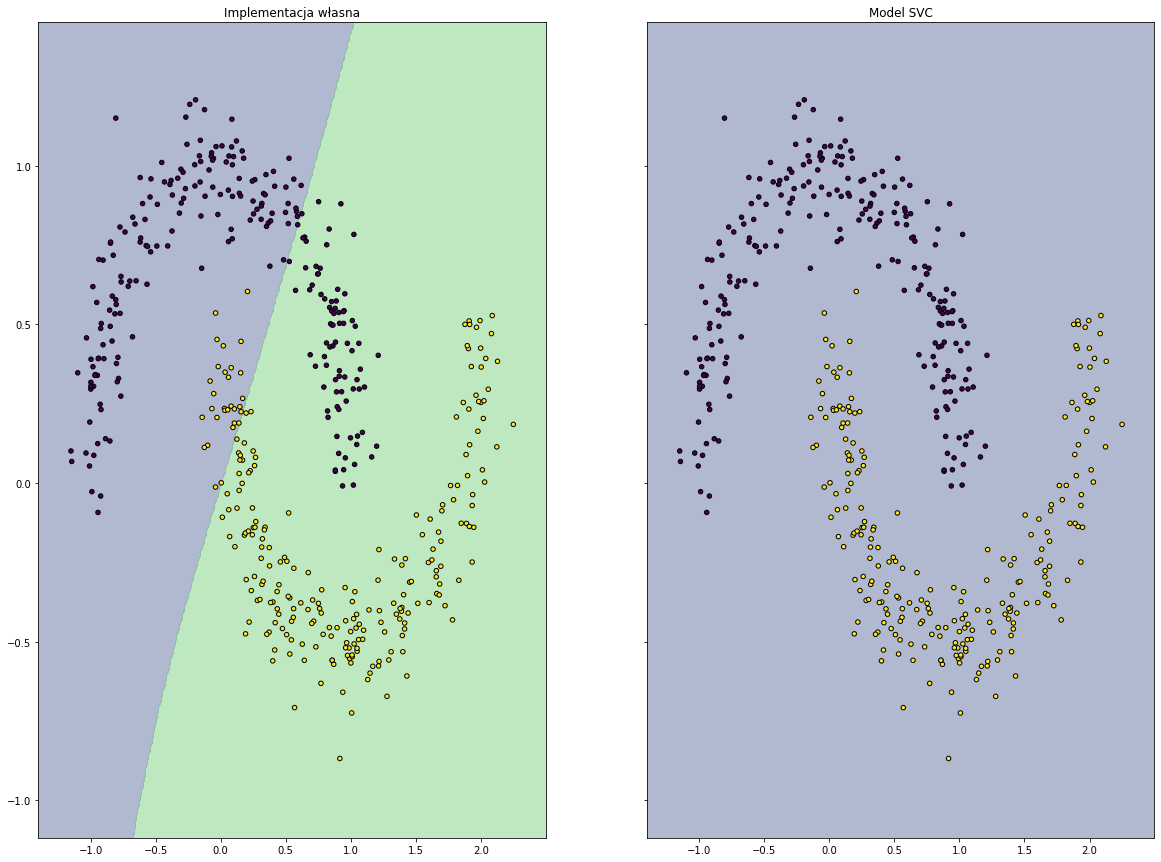

Model własny: Czulość: 0.8765432098765432, swoistość: 0.6584362139917695, Adjusted accuracy=0.5349794238683128
Model sklearn: Czulość: 1.0, swoistość: 0.0, Adjusted accuracy=0.0


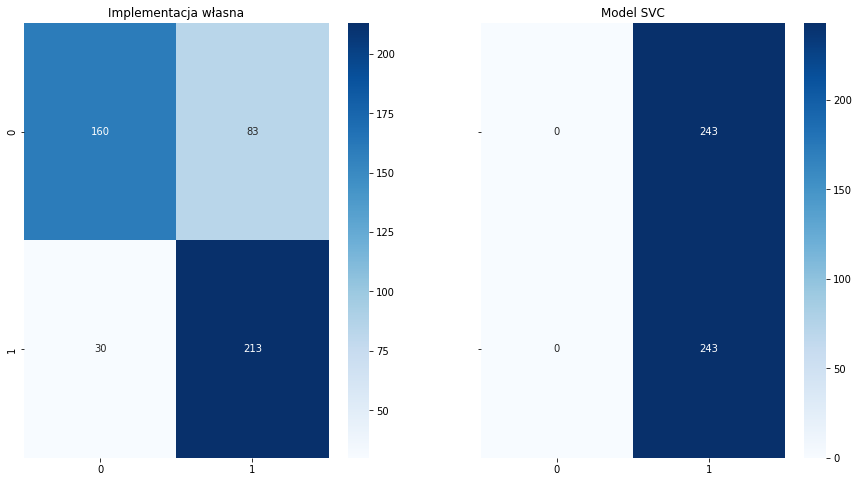

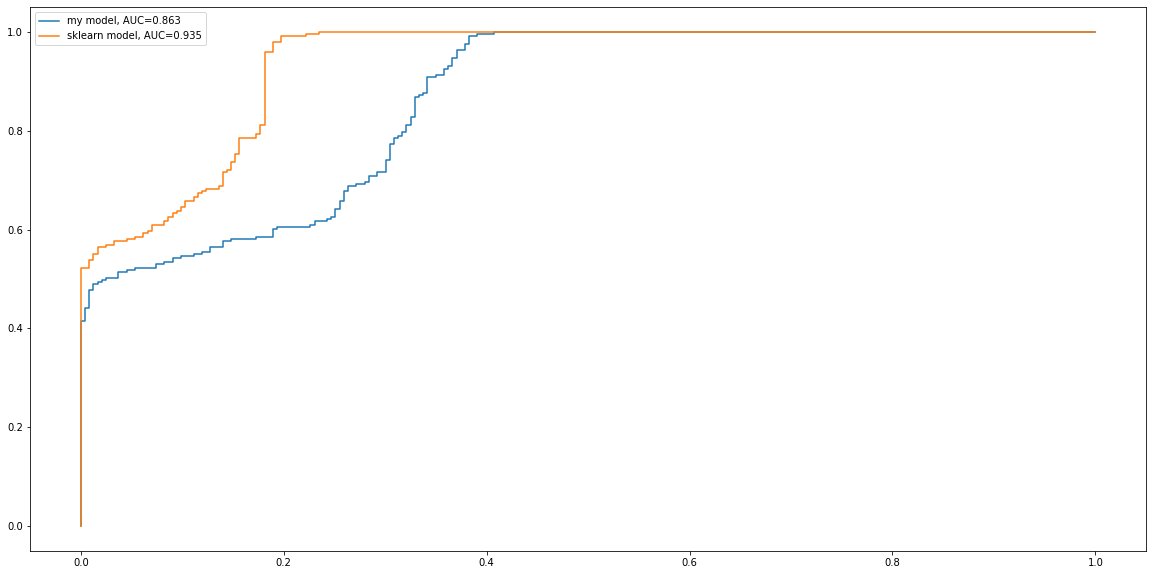

In [51]:
compare_models(new_my_model_poly, sk_model_poly, data_moons)

In [31]:
def impromptu_decision_function(self, x, data: PUMData):
    if self.coef_ is None or self.intercept_ is None:
            raise ValueError('Model is not fitted yet')

    if self.kernel == 'linear':
        return np.dot(x, self.coef_) + self.intercept_

    K = [self.kernel_function(data.small_x_train, x[i], self.degree, self.gamma) for i in range(x.shape[0])]
    return [np.dot(K[i], self.coef_) + self.intercept_ for i in range(len(K))]

def impromptu_predict(self, x, data: PUMData):
    if self.coef_ is None or self.intercept_ is None:
            raise ValueError('Model is not fitted yet')
    return np.sign(impromptu_decision_function(self, x, data))

    # value = np.zeros(x.shape[0])
    # for i in range(x.shape[0]):
    #     value[i] = np.dot(self.alpha_, self.kernel_function(x, x[i], self.degree, self.gamma)) + self.intercept_

rets = impromptu_predict(my_model_poly, data_moons.x_test, data_moons)

KeyboardInterrupt: 